In [2]:
%pip install tensorflow

  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.2.10-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   ---------------------------------------- 2.1/376.0 MB 11.7 MB/s eta 0:00:32
   ---------------------------------------- 4.5/376.0 MB 10.7 MB/s eta 0:00:35
    --------------------------------------- 7.1/376.0 MB 11.5 MB/s eta 0:00:33
   - -------------------------------------- 9.4/376.0 MB 11.3 MB/s eta 0:00:33
   - -------------------------------------- 11.8/376.0 MB 11.5 MB/s eta 0:00:32
   - ------------------------

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

from sklearn.model_selection import train_test_split
import keras
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vbekk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
df = pd.read_csv('data/train.csv')
df.head()

PermissionError: [Errno 13] Permission denied: 'data/train.csv'

In [3]:
# Check for null values
df.isnull().sum()

,0
id,0
comment_text,0
toxic,0
severe_toxic,0
obscene,0
threat,0
insult,0
identity_hate,0


# Exploratory Data Analysis

<ipython-input-9-17fb2dd4afab>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['Non-Toxic', 'Toxic'], y=[non_toxic_count, toxic_count], palette='coolwarm')


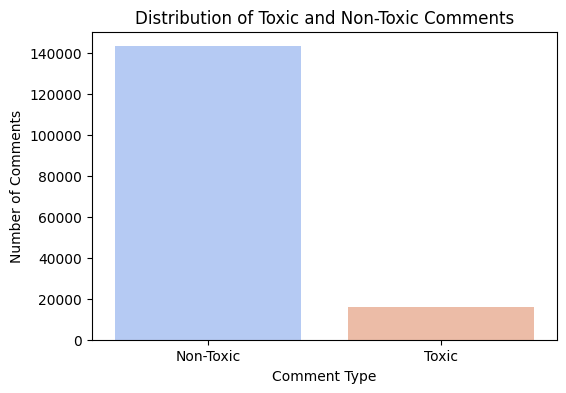

In [9]:
# Distribution of Toxic and Non-Toxic Comments
targets = list(df.columns[2:])
df_targets = df[targets].copy()

# rows having atleast one positive label for a comment
toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)

# Count toxic and non-toxic comments
toxic_count = toxic_rows.sum()
non_toxic_count = len(toxic_rows) - toxic_count

# Bar chart for toxic vs. non-toxic
plt.figure(figsize=(6,4))
sns.barplot(x=['Non-Toxic', 'Toxic'], y=[non_toxic_count, toxic_count], palette='coolwarm')
plt.title('Distribution of Toxic and Non-Toxic Comments')
plt.ylabel('Number of Comments')
plt.xlabel('Comment Type')
plt.show()


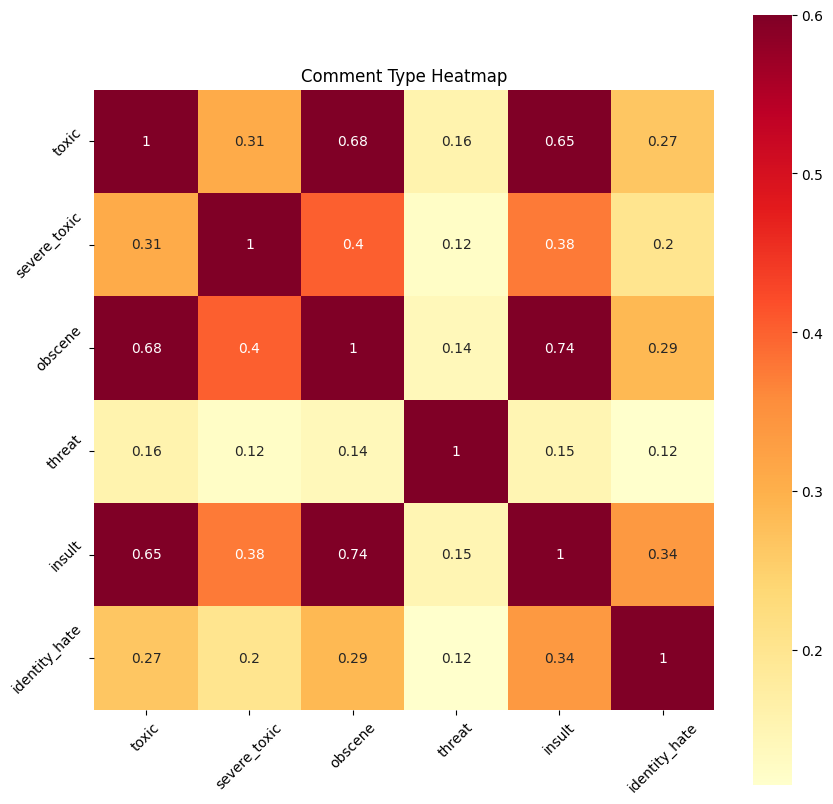

In [8]:
# Calculate Label Co-occurrences
count_dic = {}
for comment_type in targets:
    counts = list()
    others = list(targets)
    df_selection = df_targets[(df_targets[comment_type]==1)]
    others.remove(comment_type)
    counts.append(('total', len(df_selection)))
    for other in others:
        counts.append((other, df_selection[other].sum()))
    count_dic[comment_type] = counts

def heatmap(df, title):
    plt.figure('heatmap', figsize=[10,10])
    plt.title(title)
    df_corr = df.corr()
    sns.heatmap(df_corr, vmax=0.6, square=True, annot=True, cmap='YlOrRd')
    plt.yticks(rotation = 45)
    plt.xticks(rotation = 45)
    plt.show()

heatmap(df_targets, 'Comment Type Heatmap')


16225 out of 159571 comments, or 10.17%, are classified as toxic.

15294 toxic comments. (9.58% of all data.)
- 1595 or 10.43% were also severe_toxic.
- 7926 or 51.82% were also obscene.
- 449 or 2.94% were also threat.
- 7344 or 48.02% were also insult.
- 1302 or 8.51% were also identity_hate.

1595 severe_toxic comments. (1.00% of all data.)
- 1595 or 100.00% were also toxic.
- 1517 or 95.11% were also obscene.
- 112 or 7.02% were also threat.
- 1371 or 85.96% were also insult.
- 313 or 19.62% were also identity_hate.

8449 obscene comments. (5.29% of all data.)
- 7926 or 93.81% were also toxic.
- 1517 or 17.95% were also severe_toxic.
- 301 or 3.56% were also threat.
- 6155 or 72.85% were also insult.
- 1032 or 12.21% were also identity_hate.

478 threat comments. (0.30% of all data.)
- 449 or 93.93% were also toxic.
- 112 or 23.43% were also severe_toxic.
- 301 or 62.97% were also obscene.
- 307 or 64.23% were also insult.
- 98 or 20.50% were also identity_hate.

7877 insult commen

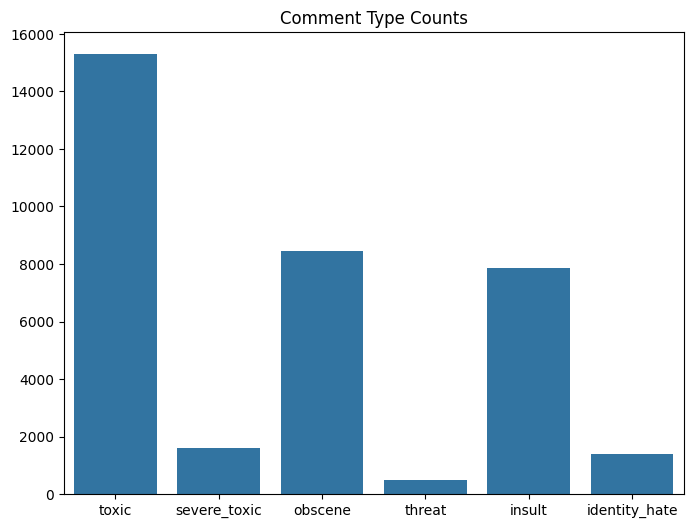

In [ ]:
# comment toxicity and type distributions

print('%d out of %d comments, or %.2f%%, are classified as toxic.' %
     (np.sum(toxic_rows), len(df), (np.sum(toxic_rows)/len(df))*100))

totals = []
for key, value in count_dic.items():
  # Add the count of comments of each type to the 'totals' list
    totals.append(value[0][1])
    print('\n%d %s comments. (%.2f%% of all data.)' % (value[0][1], key, (value[0][1]/len(df))*100))
    for cnt in value[1:]:
        print('- %d or %.2f%% were also %s.' % (cnt[1], (cnt[1]/value[0][1])*100, cnt[0]))


plt.figure('Comment Type Counts', figsize=[8,6])
plt.title('Comment Type Counts')
sns.barplot(x=list(count_dic.keys()), y=totals)
plt.show()

The lower overlap of "identity_hate" and "threat" with other labels shows that it has more unique linguistic or contextual features which could make it easier for models to learn and predict. The category "threat" does appear to have even less overlap than "identity_hate," making it potentially easier to predict in terms of distinctiveness. However, its smaller volume (0.30% vs. 0.88%) may introduce challenges due to class imbalance, which "identity_hate" might not face to the same extent.

In [ ]:
# Calculate average comment length

df['length'] = df.comment_text.apply(lambda x: len(x))
print("Average toxic comment length: %d" % int(np.mean(df[df[targets].sum(axis=1) > 0].length)))
print("Average clean comment length: %d" % int(np.mean(df[df[targets].sum(axis=1) == 0].length)))

Average toxic comment length: 303
Average clean comment length: 404


In [ ]:
# Calculate percent of capitalized characters

def pct_caps(s):
    return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))
print("Percent of capitalized characters in toxic comments: %d%%" % int(100 * np.mean(df[df[targets].sum(axis=1) > 0].caps)))
print("Percent of capitalized characters in clean comments: %d%%" % int(100 * np.mean(df[df[targets].sum(axis=1) == 0].caps)))

Percent of capitalized characters in toxic comments: 14%
Percent of capitalized characters in clean comments: 5%


In [ ]:
# Calculate number of exclamations
df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))
print("Exclamations in toxic comments: %.1f" % np.mean(df[df[targets].sum(axis=1) > 0].exclamation))
print("Exclamations in clean comments: %.1f" % np.mean(df[df[targets].sum(axis=1) == 0].exclamation))

Exclamations in toxic comments: 3.5
Exclamations in clean comments: 0.3


In [ ]:
# Calculate number of question marks
df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))
print("Question marks in toxic comments: %.1f" % np.mean(df[df[targets].sum(axis=1) > 0].question))
print("Question marks in clean comments: %.1f" % np.mean(df[df[targets].sum(axis=1) == 0].question))

Question marks in toxic comments: 0.6
Question marks in clean comments: 0.4


Label overlap summary.
1 label: 39.2%
2 labels: 21.4%
3 labels: 25.9%
4 labels: 10.8%
5 labels: 2.4%
6 labels: 0.2%


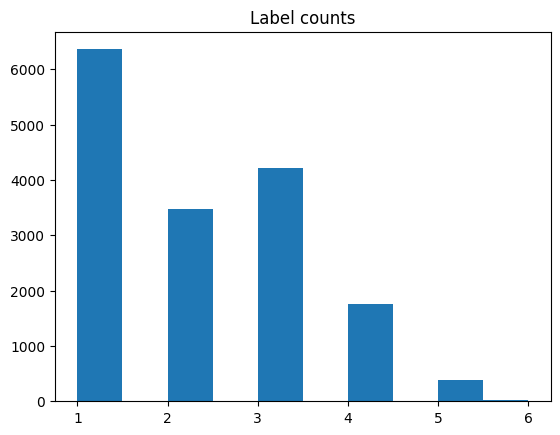

In [ ]:
# summarize the distribution of label overlaps in the dataset
target_sums = np.sum(df_targets[df_targets.columns], axis=1)
target_sums = target_sums[df[targets].sum(axis=1) > 0]
plt.figure('Label counts')
plt.title('Label counts')
plt.hist(target_sums)
print("Label overlap summary.")
for i in range(1,7):
    print('%d label%s: %.1f%%' % (i, 's' if i > 1 else '', 100 * len([s for s in target_sums if s == i])/len(target_sums)))

**Spliting Labels from Training Data**

In [ ]:
print('Training labels:')
print(list(df_targets.columns))
print(df_targets.shape)

print('\nTraining data')
df.drop(list(df_targets.columns), inplace=True, axis=1)
df.drop('id', inplace=True, axis=1)
print(list(df.columns))
print(df.shape)

Training labels:
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
(159571, 6)

Training data
['comment_text', 'length', 'caps', 'exclamation', 'question']
(159571, 5)


**Tokenization**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from nltk.corpus import stopwords
import string

top_words = 5000
tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True, num_words=top_words)
tokenizer.fit_on_texts(df['comment_text'])

In [ ]:
df['comment_sequence'] = tokenizer.texts_to_sequences(df.comment_text.str.lower())

**Find the ideal word count cut-off for text analysis.**

In [ ]:
max_len = df.comment_sequence.map(lambda x: len(x)).max()
print("Max comment length is %d." % max_len)

Max comment length is 1399.


In [ ]:
seq_lens = df.comment_sequence.map(lambda x: len(x))
for i in [10, 50, 100, 200, 300, 400, 500, 1000, 1200]:
    select = (seq_lens > i)
    print('%.2f%% of comments have more than %d words.' % ((np.sum(select)/len(seq_lens))*100, i))

83.73% of comments have more than 10 words.
35.36% of comments have more than 50 words.
16.08% of comments have more than 100 words.
5.61% of comments have more than 200 words.
2.63% of comments have more than 300 words.
1.63% of comments have more than 400 words.
1.09% of comments have more than 500 words.
0.02% of comments have more than 1000 words.
0.01% of comments have more than 1200 words.



The first 300 words of a long comment give a good sense of what the whole comment is about. Basically, the tone and sentiment are usually set right at the beginning. It also suggests that big changes in tone, like going from neutral to racist language, are unlikely to happen after the first part. So, those first 300 words are taken as a cutoff.

**Visualize Word Count**

In [ ]:
def get_word_count(tokenizer):
    word_count = [(k, v) for k, v in zip(tokenizer.word_counts.keys(),
                                       tokenizer.word_counts.values())]
    word_count.sort(key = lambda tup: tup[1], reverse=True)
    stopWords = set(stopwords.words('english'))
    word_count = [tup for tup in word_count if tup[0] not in stopWords]
    return word_count

def word_plot(word_count, num_words, title):
    plt.figure(title, figsize=(24, 12))
    plt.suptitle(title, fontsize=40)
    sns.barplot(x= [tup[0] for tup in word_count[0:num_words]],
                y = [tup[1] for tup in word_count[0:num_words]])
    plt.yticks(fontsize=20)
    plt.xticks(fontsize=20, rotation=35, ha='right')
    plt.show()

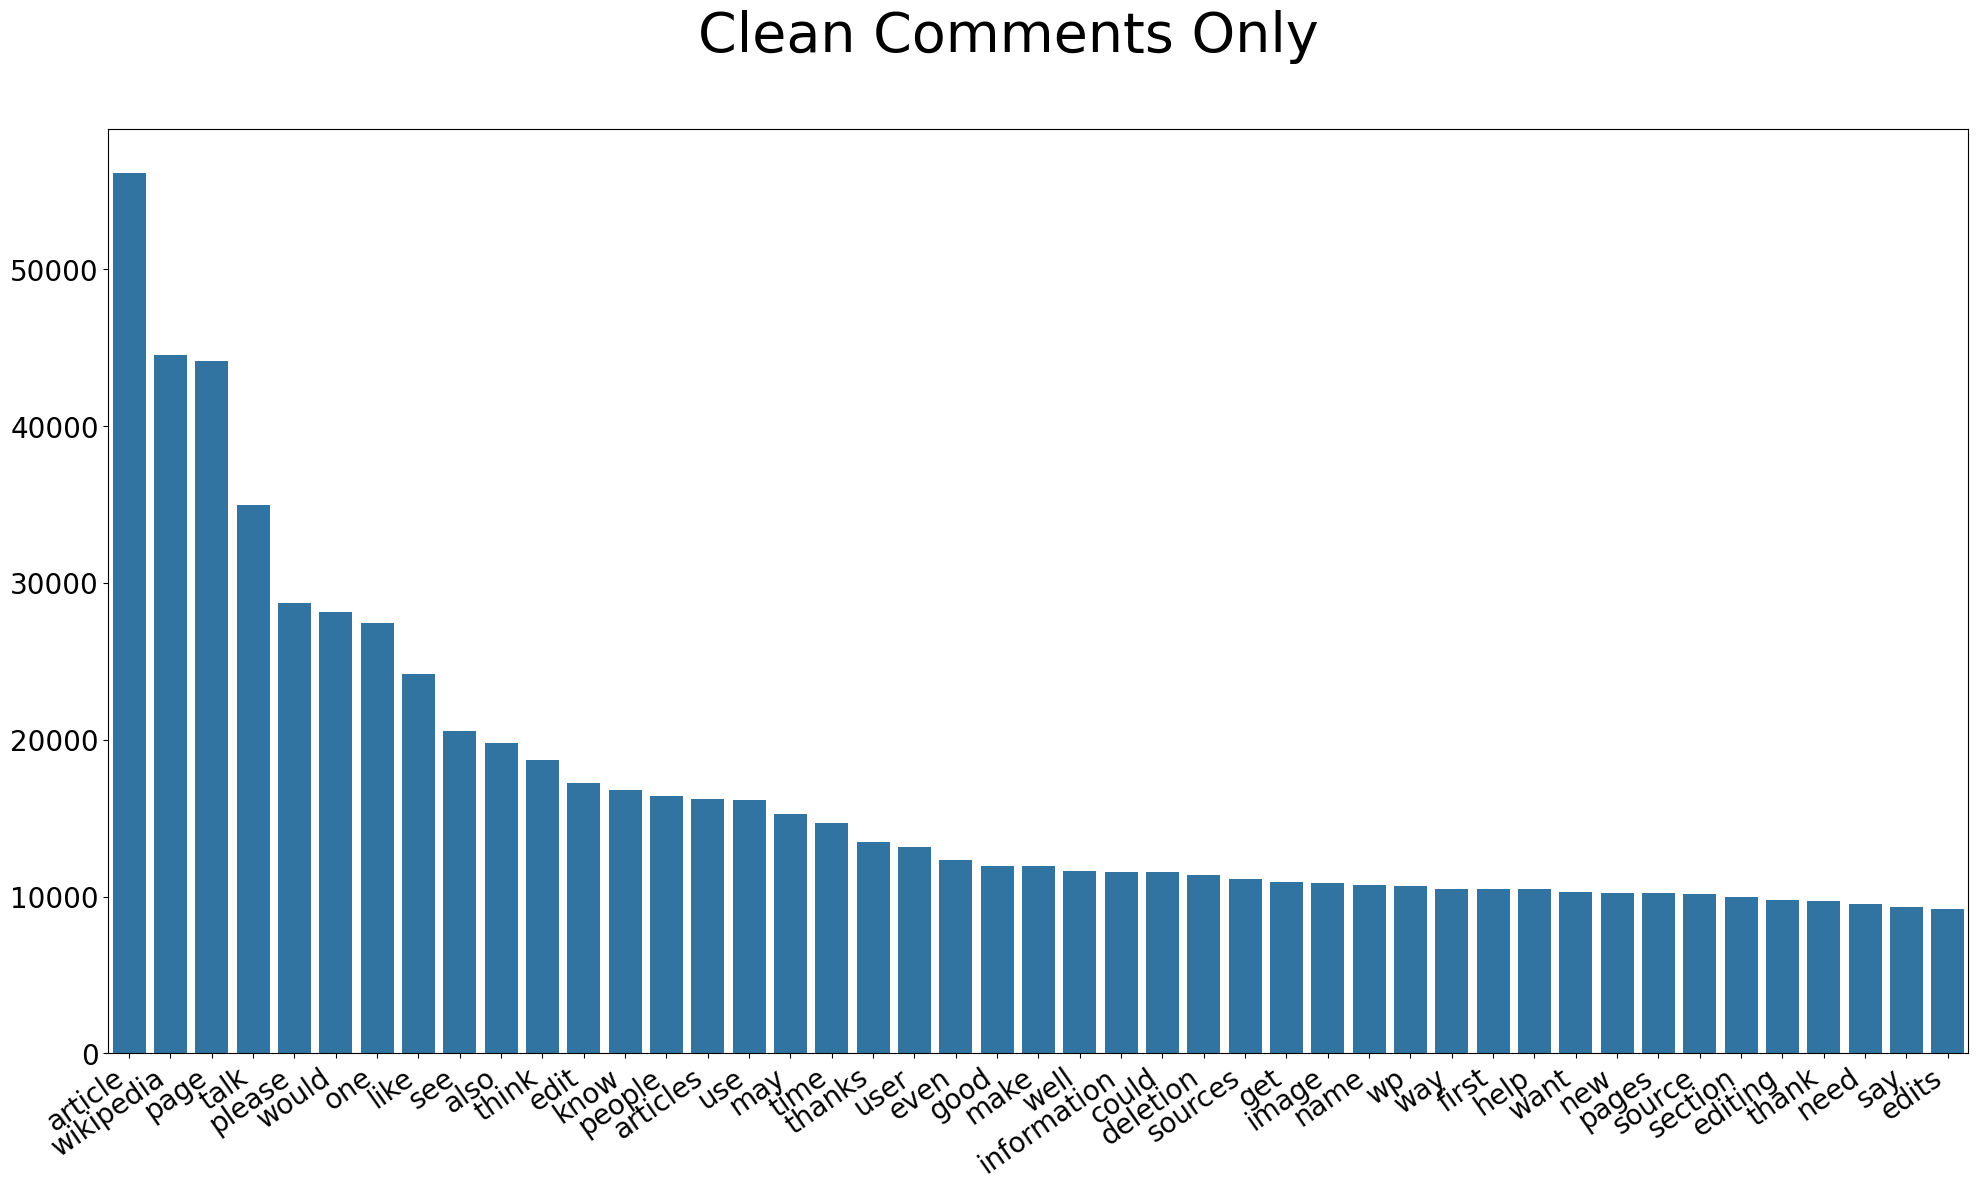

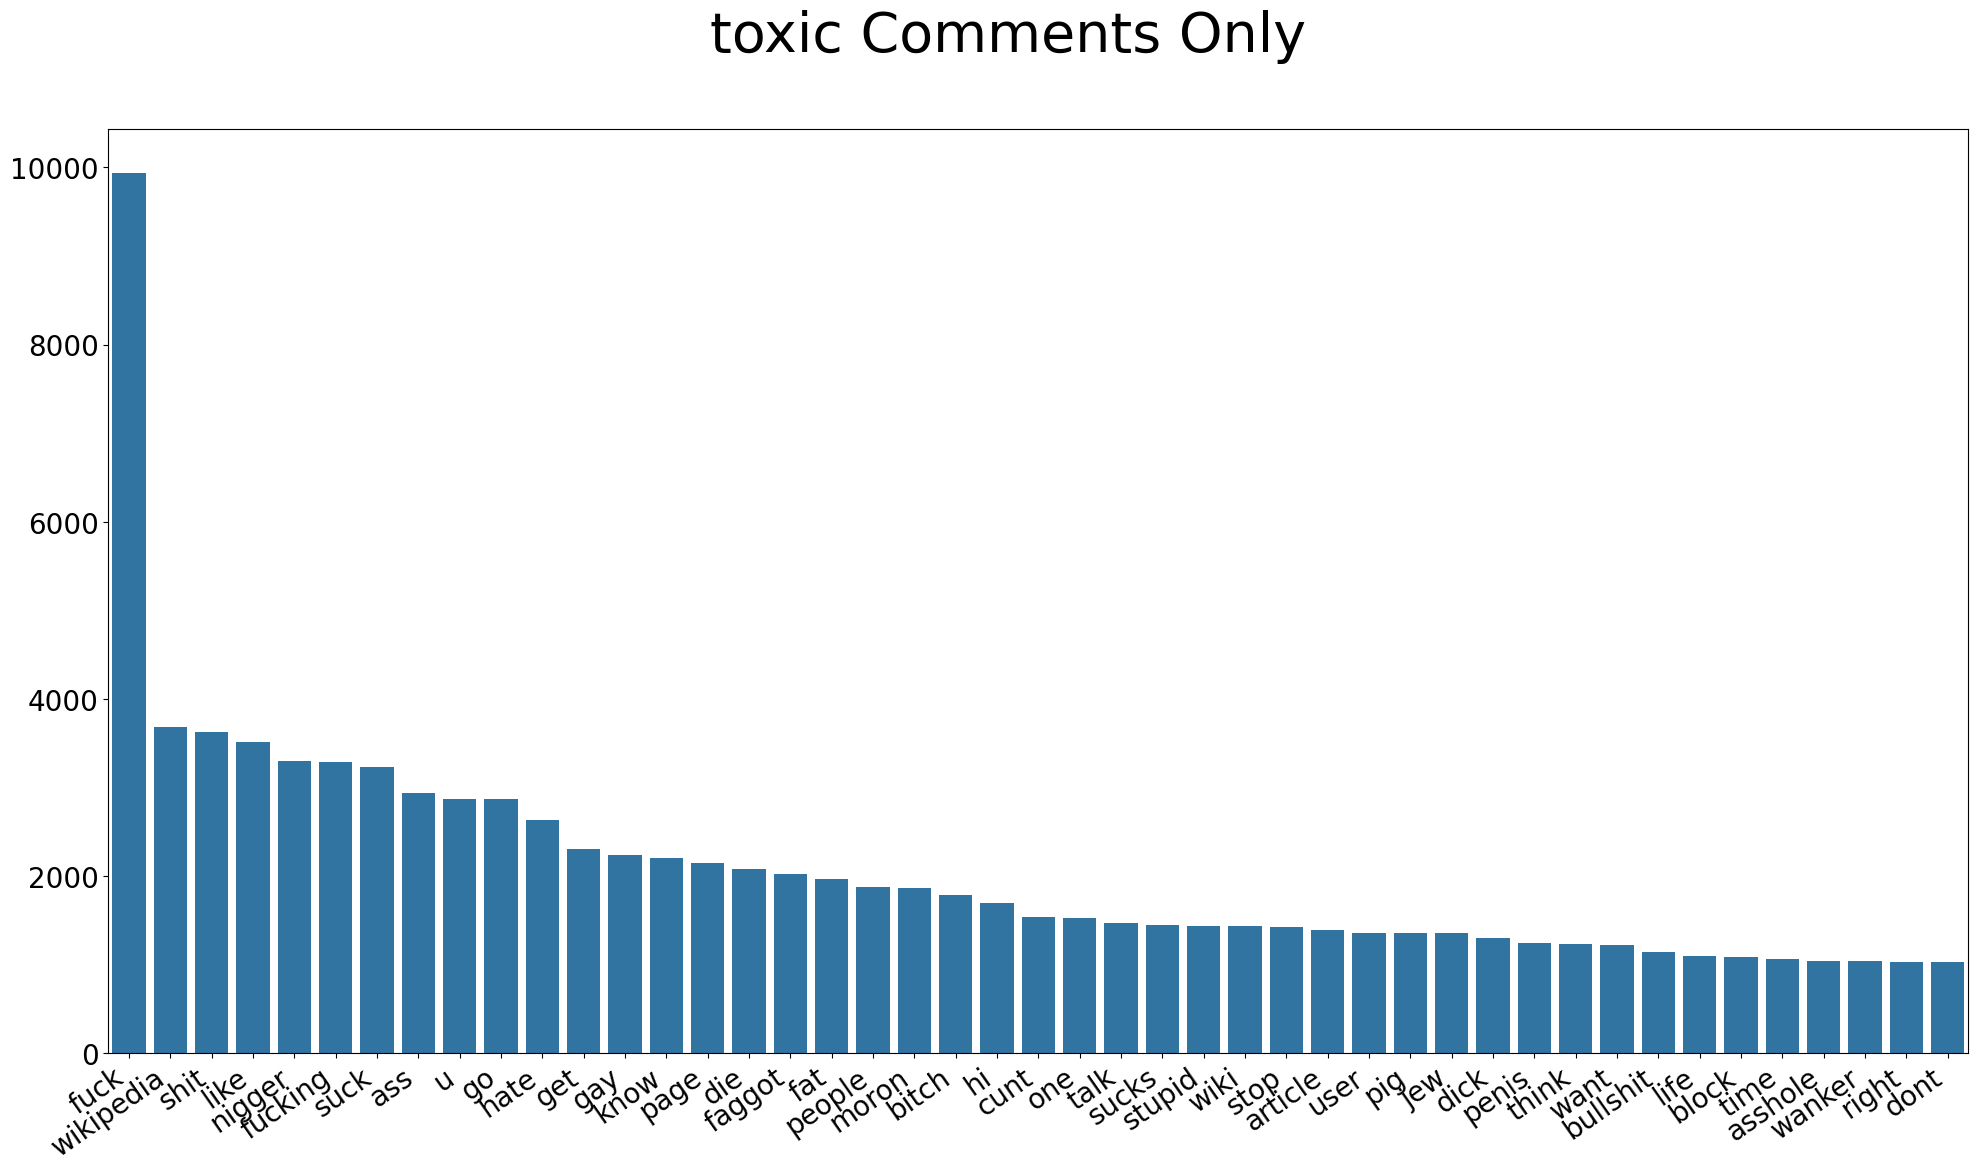

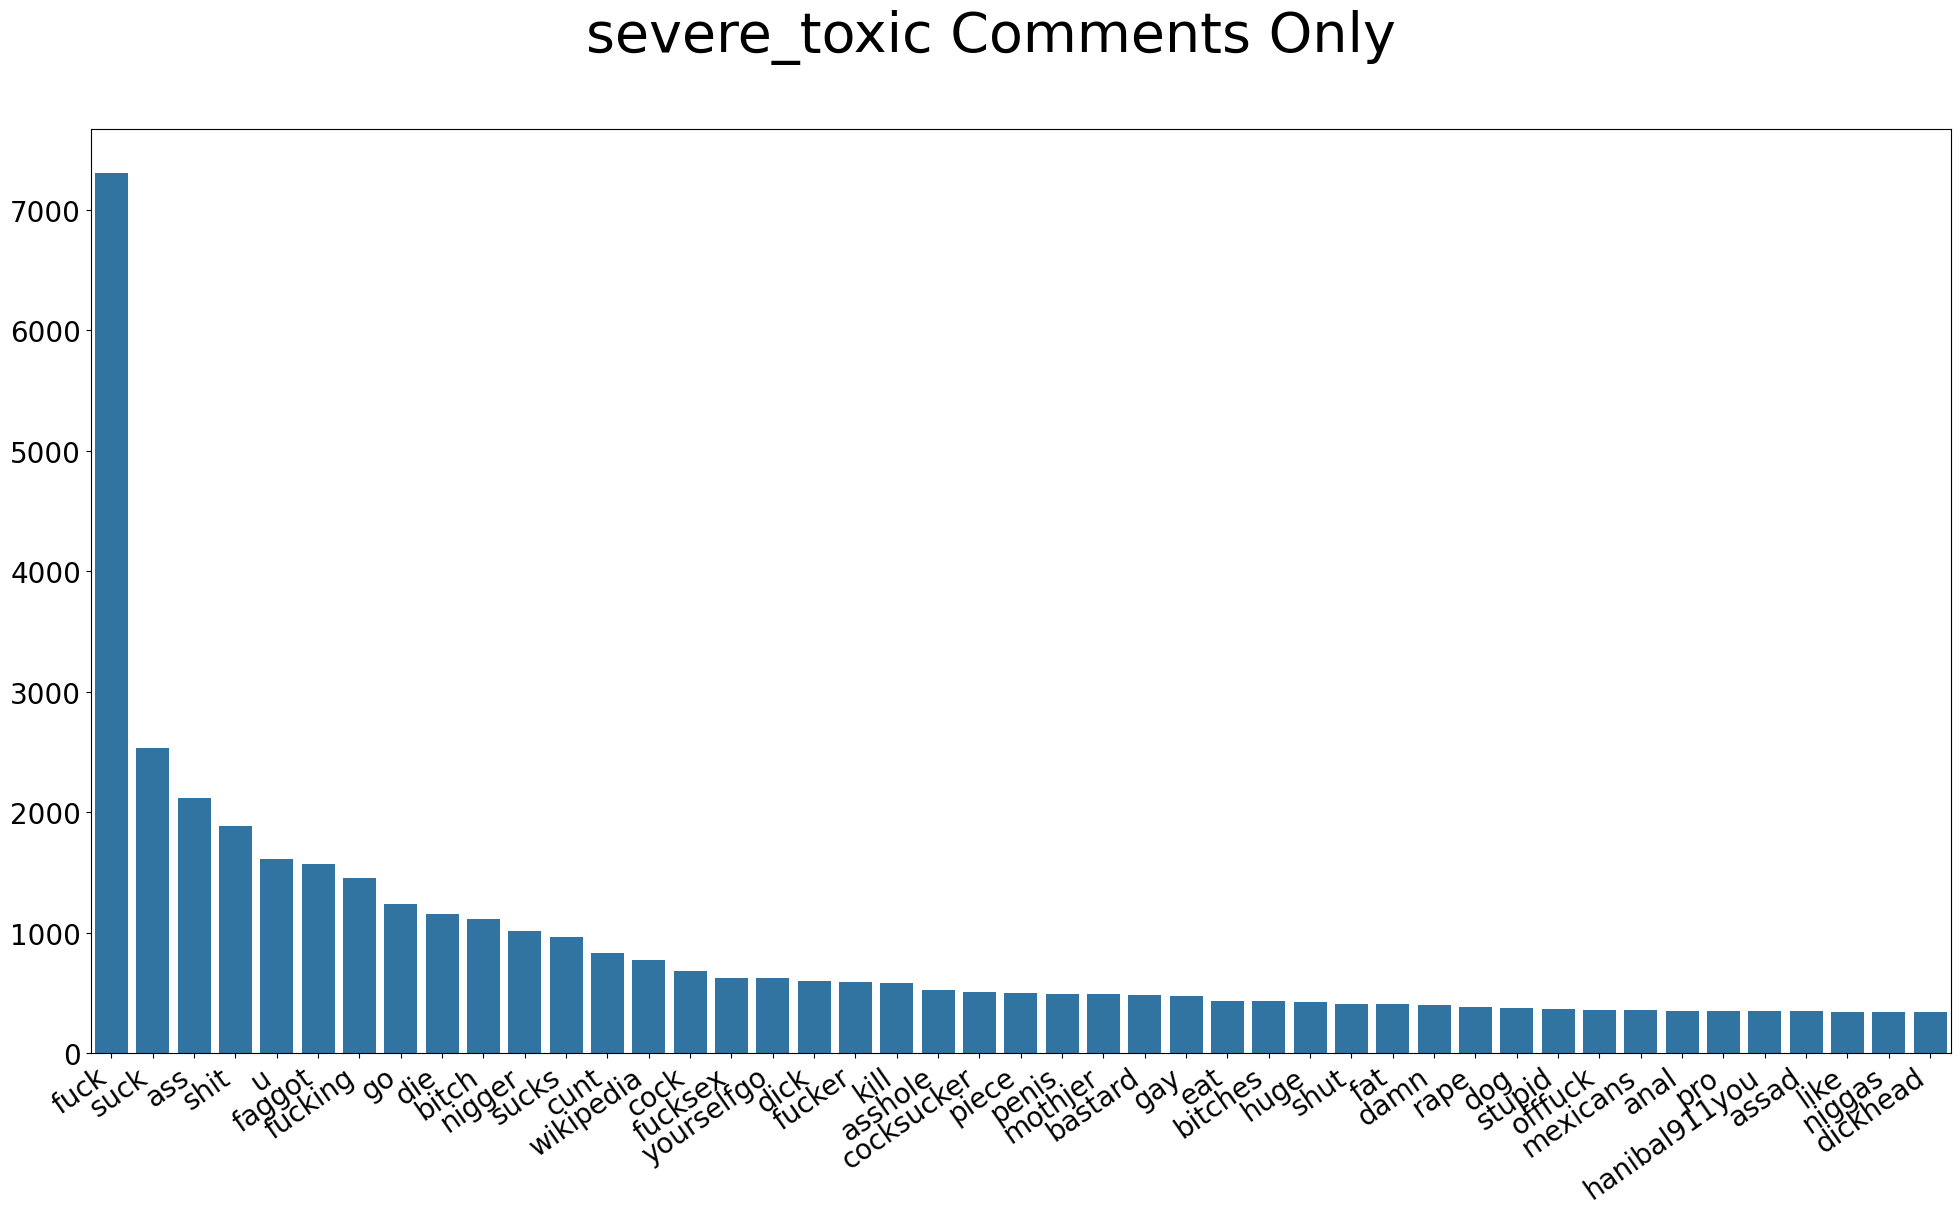

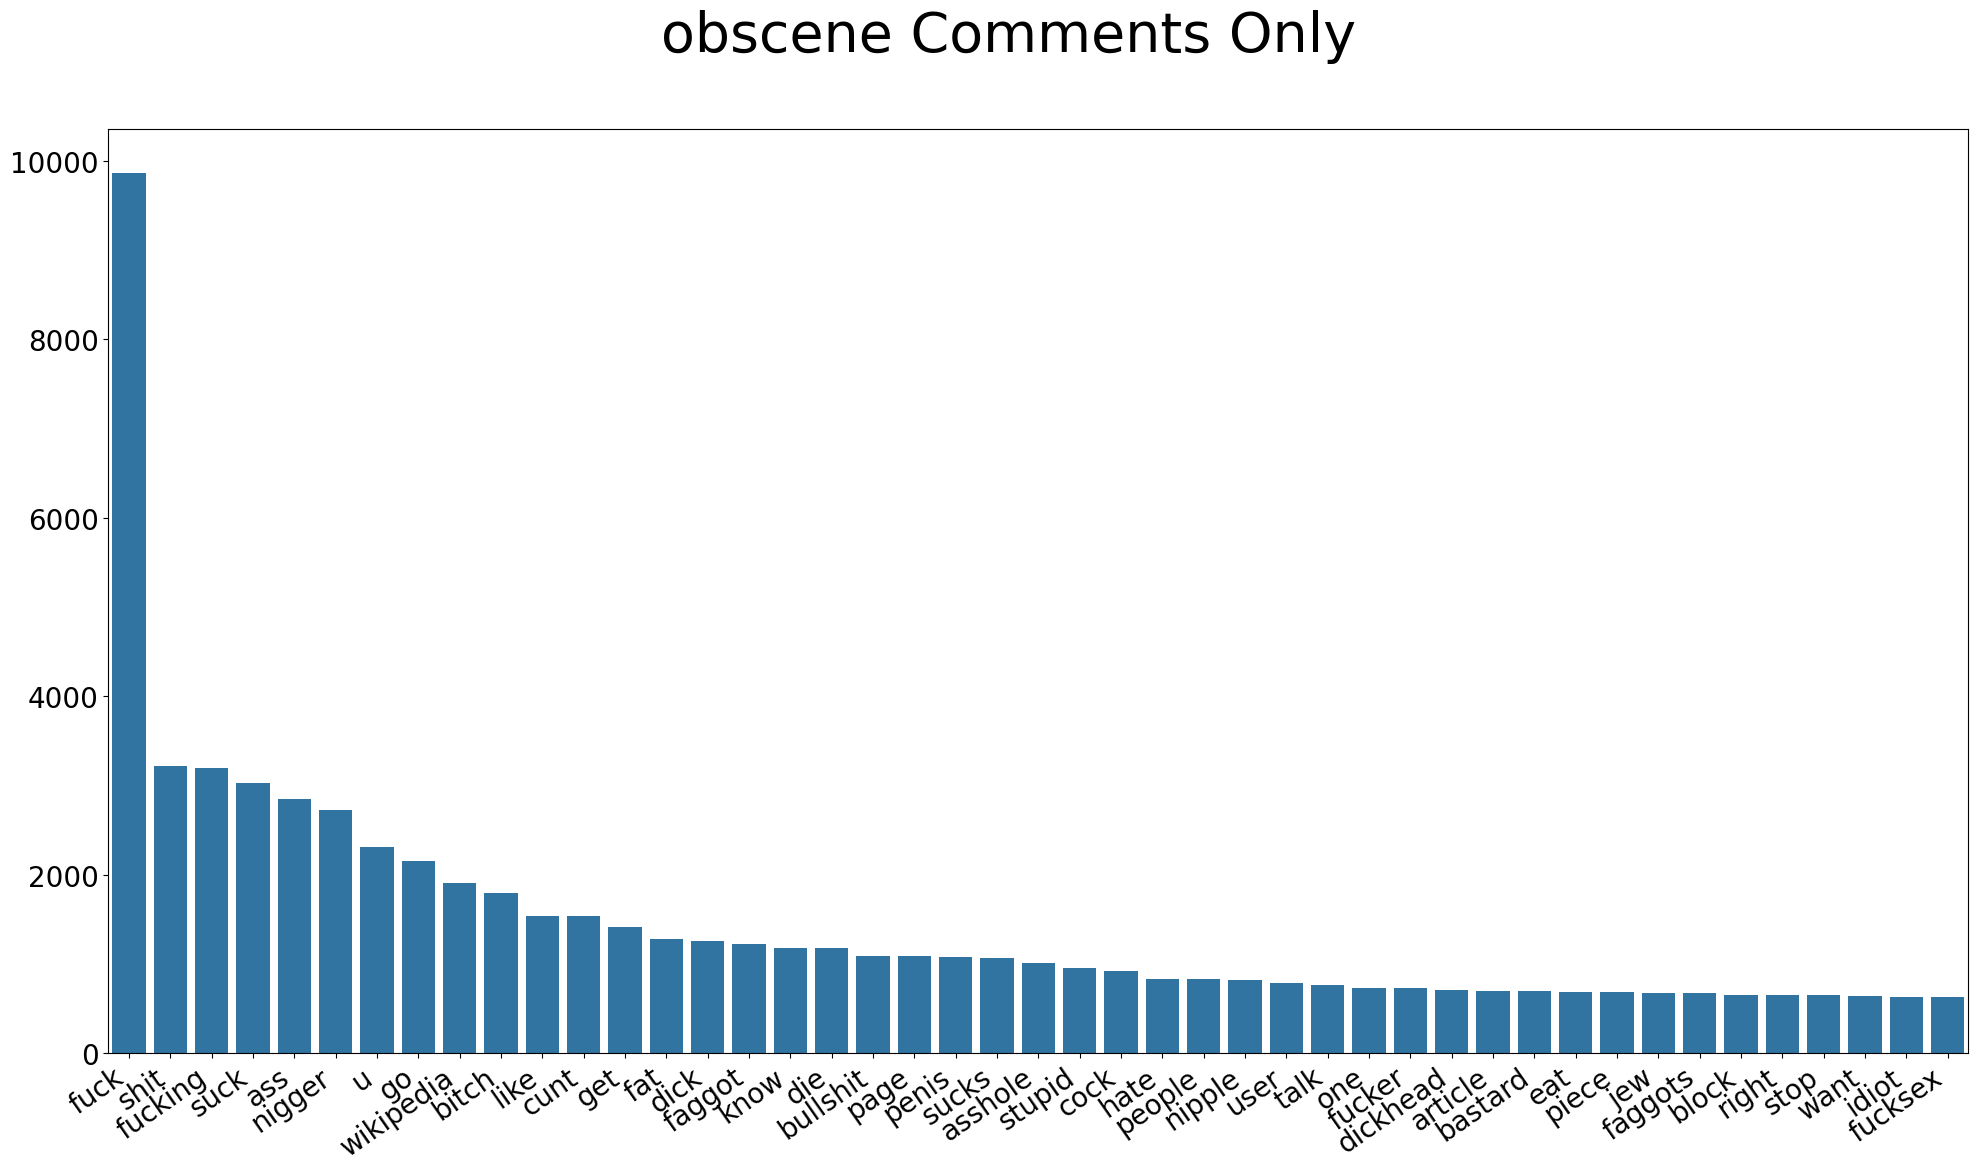

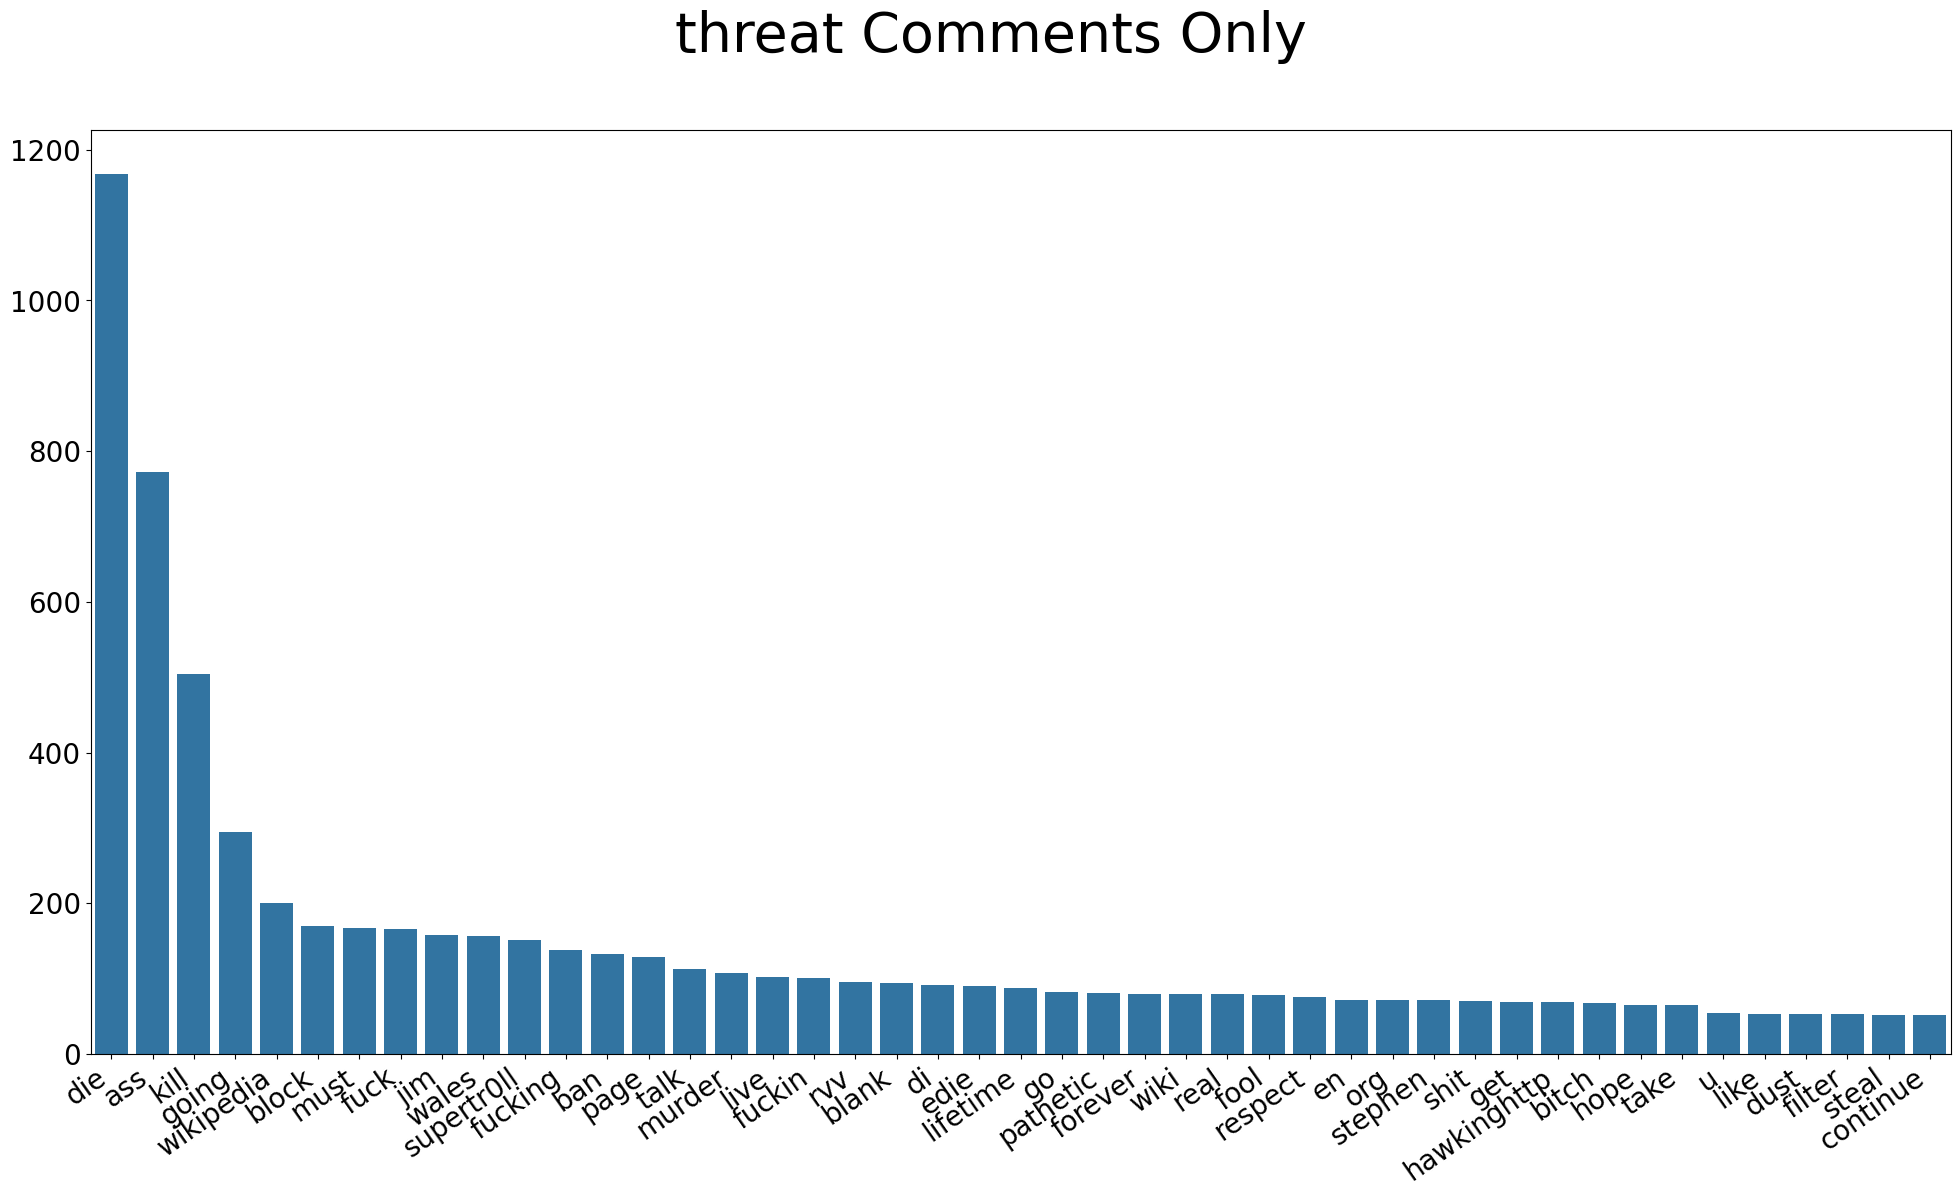

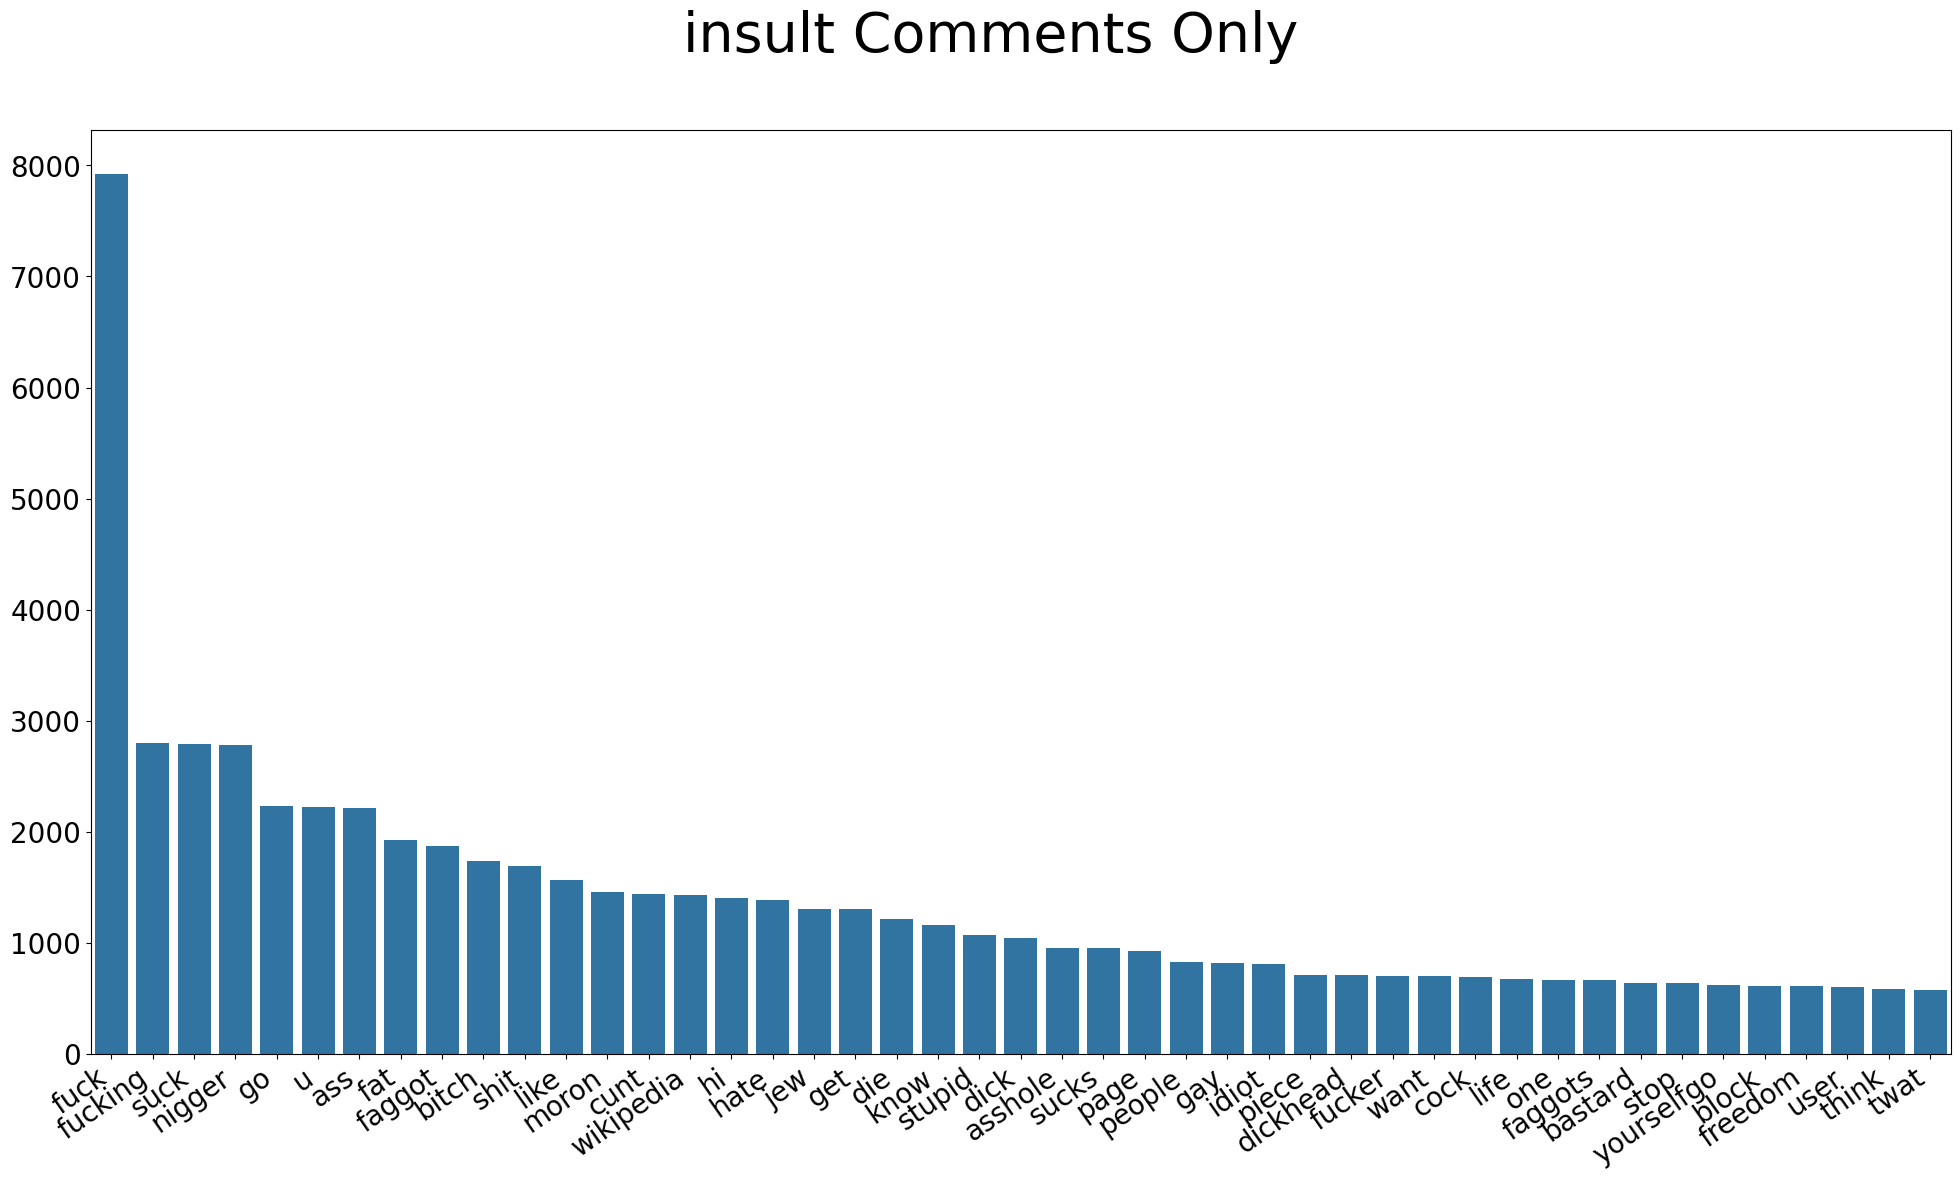

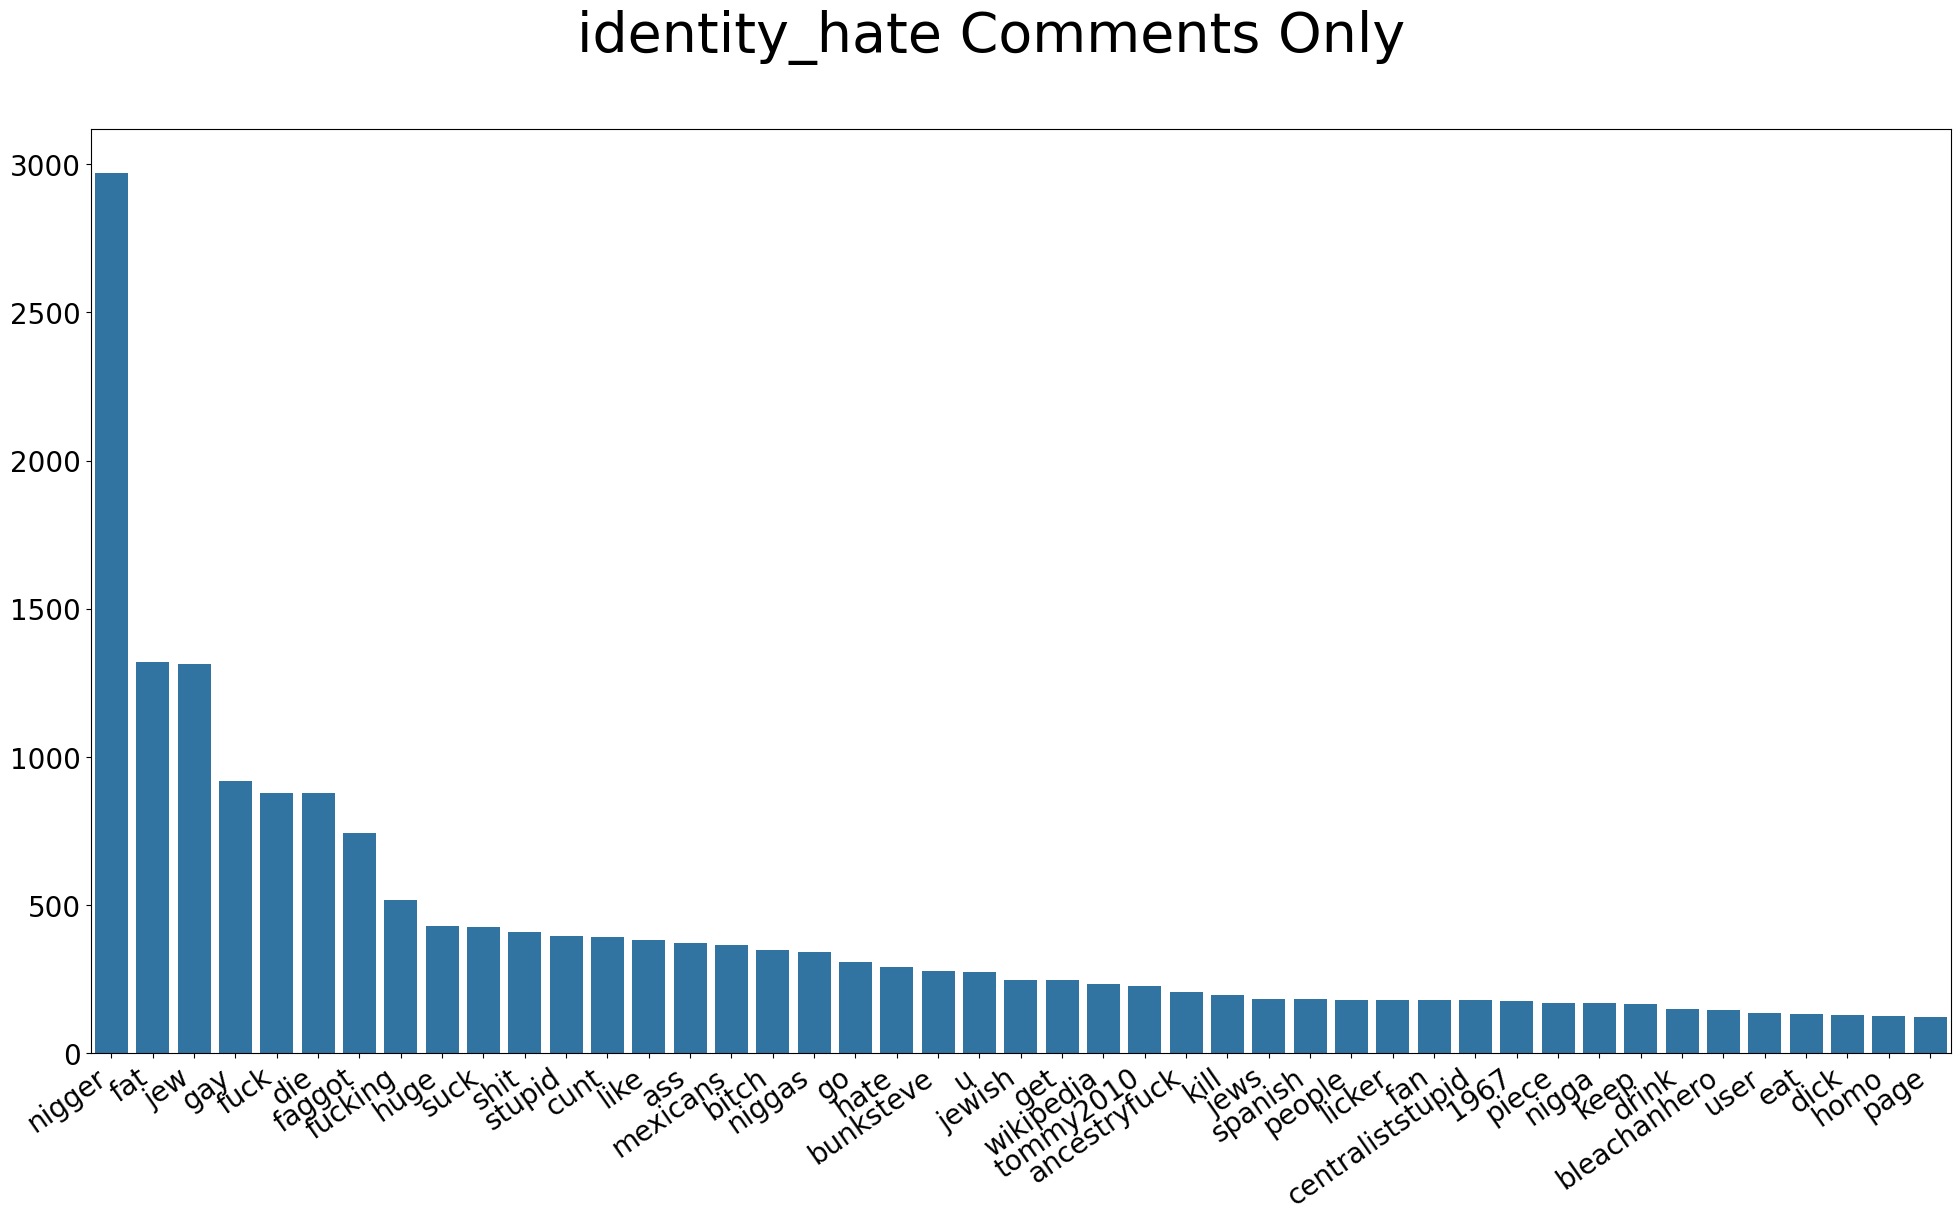

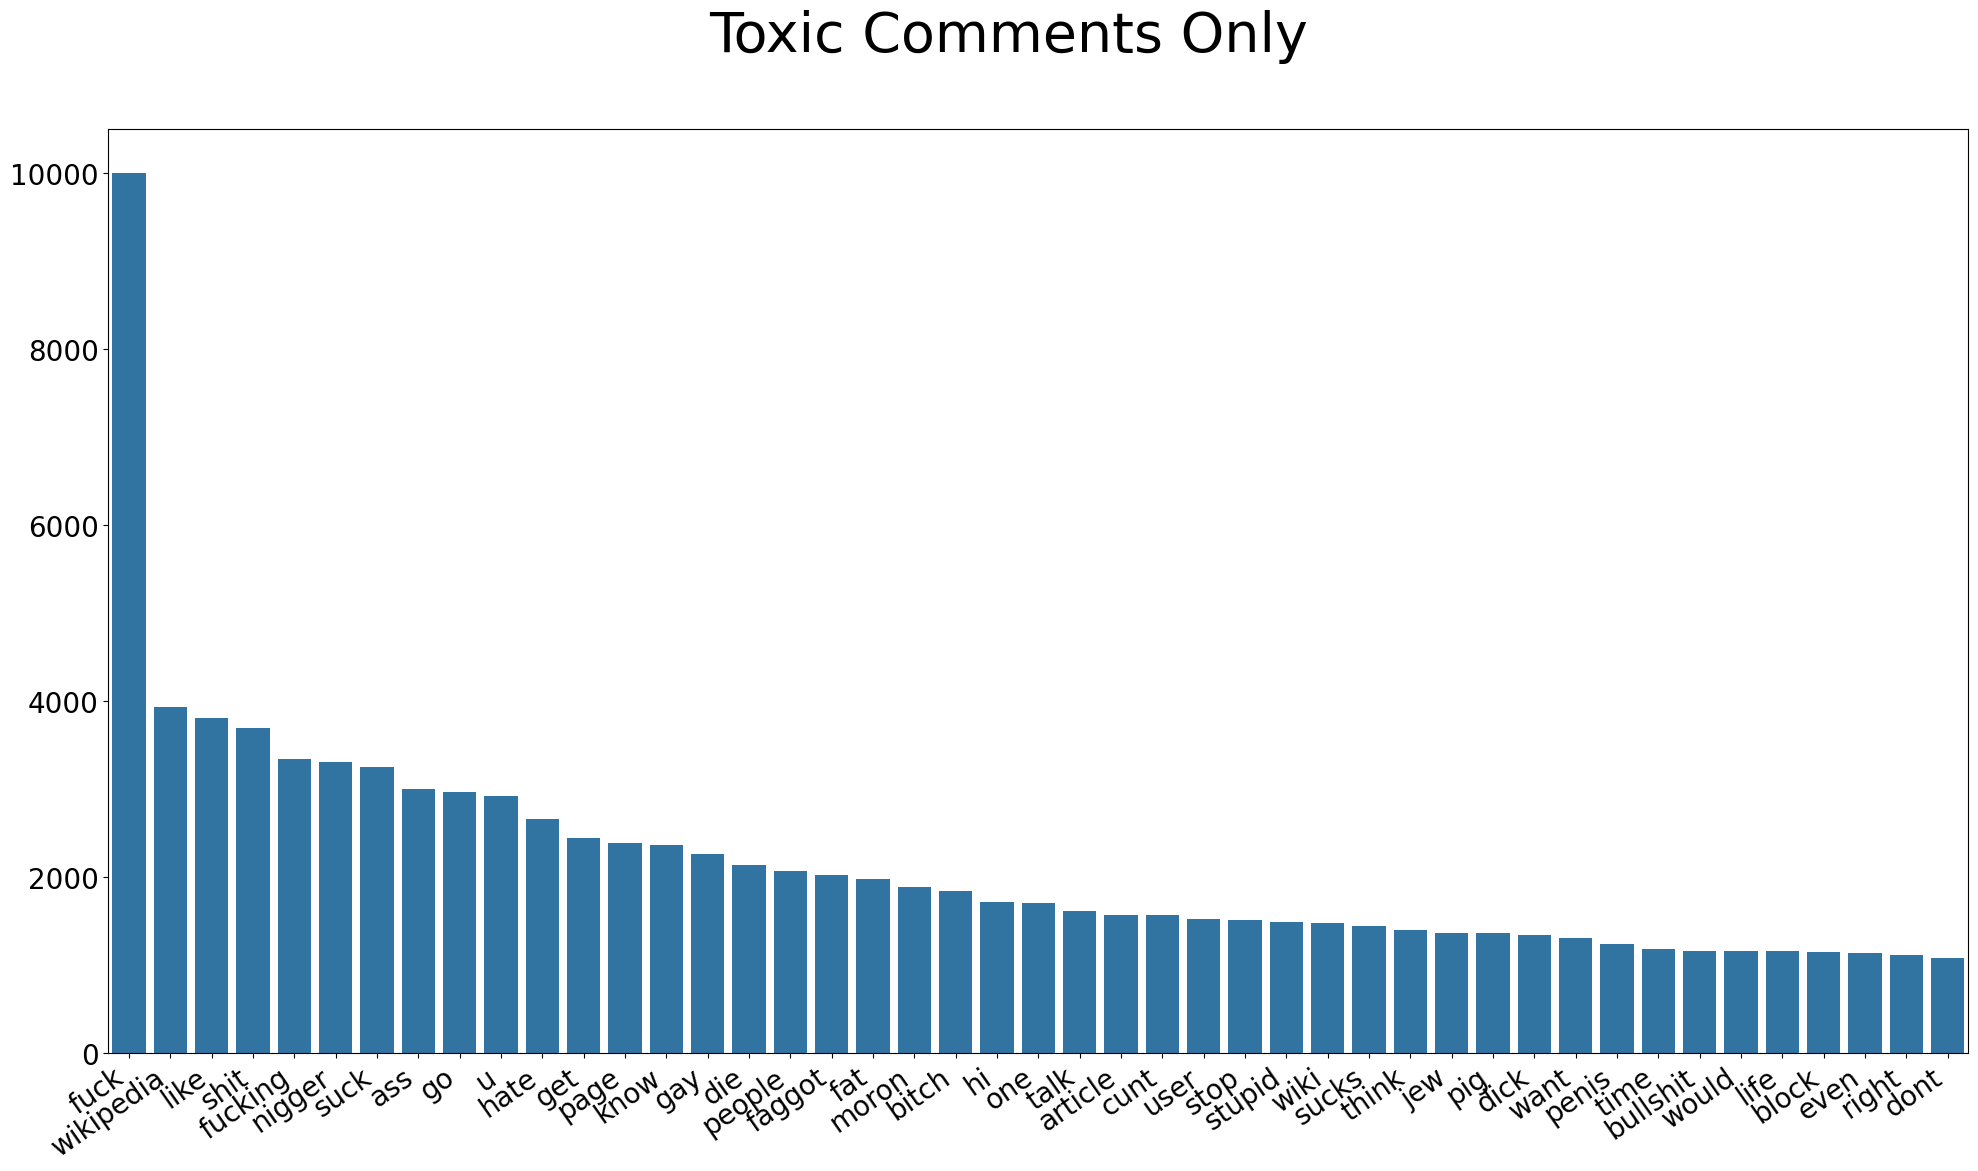

In [ ]:
all_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
all_tokenizer.fit_on_texts(df.comment_text[(toxic_rows==0)])
word_plot(get_word_count(all_tokenizer), 45, 'Clean Comments Only')

for label in targets:
    toxic_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
    toxic_tokenizer.fit_on_texts(df.comment_text[(df_targets[label]==1)])
    word_plot(get_word_count(toxic_tokenizer), 45, label + ' Comments Only')

toxic_tokenizer = Tokenizer(filters=string.punctuation+'\n', lower=True)
toxic_tokenizer.fit_on_texts(df.comment_text[toxic_rows])
word_plot(get_word_count(toxic_tokenizer), 45, 'Toxic Comments Only')

# Model Building

In [ ]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
import re
from scipy import sparse
from sklearn.base import clone
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_union


In [ ]:
# Global random state and k-fold strategy
seed = 42
k = 5
cv = StratifiedKFold(n_splits=k, random_state=seed, shuffle=True)

**Feature Engineering**

In [ ]:
def feature_engineering(df, sparse=0):

    # Comment length
    df['length'] = df.comment_text.apply(lambda x: len(x))

    # Capitalization percentage
    def pct_caps(s):
        return sum([1 for c in s if c.isupper()]) / (sum(([1 for c in s if c.isalpha()])) + 1)
    df['caps'] = df.comment_text.apply(lambda x: pct_caps(x))

    # Average number of exclamation points
    df['exclamation'] = df.comment_text.apply(lambda s: len([c for c in s if c == '!']))

    # Average number of question marks
    df['question'] = df.comment_text.apply(lambda s: len([c for c in s if c == '?']))

    # Normalize
    for label in ['length', 'caps', 'question', 'exclamation']:
        minimum = df[label].min()
        diff = df[label].max() - minimum
        df[label] = df[label].apply(lambda x: (x-minimum) / (diff))

    # Remove IP Address
    ip = re.compile('(([2][5][0-5]\.)|([2][0-4][0-9]\.)|([0-1]?[0-9]?[0-9]\.)){3}'
                    +'(([2][5][0-5])|([2][0-4][0-9])|([0-1]?[0-9]?[0-9]))')
    def strip_ip(s, ip):
        try:
            found = ip.search(s)
            return s.replace(found.group(), ' ')
        except:
            return s

    df.comment_text = df.comment_text.apply(lambda x: strip_ip(x, ip))

    return df

def merge_features(comment_text, data, engineered_features):
    new_features = sparse.csr_matrix(data[engineered_features].values) #Change into dense matrix for merging later
    if np.isnan(new_features.data).any():
        new_features.data = np.nan_to_num(new_features.data)
    return sparse.hstack([comment_text, new_features])

In [ ]:
train_data = pd.read_csv('/content/drive/MyDrive/NLP Project 2/data/train.csv')
targets = list(train_data.columns[2:])
df_targets = train_data[targets].copy()

test_data = pd.read_csv('/content/drive/MyDrive/NLP Project 2/data/test.csv', dtype={'id': object}, na_filter=False)

# Feature Engineering
df_train = feature_engineering(train_data)
df_test = feature_engineering(test_data)

print('Training labels:')
print(list(df_targets.columns))
print(df_targets.shape)

print('\nTraining data')
df_train.drop(list(df_targets.columns), inplace=True, axis=1)
df_train.drop('id', inplace=True, axis=1)
print(list(df_train.columns))
print(df_train.shape)

print('\nTest data')
df_test.drop('id', inplace=True, axis=1)
print(list(df_test.columns))
print(df_test.shape)

# rows having atleast one toxic category
toxic_rows = df_targets.sum(axis=1)
toxic_rows = (toxic_rows > 0)
targets.append('any_label')
df_targets['any_label'] = toxic_rows.astype(int)

new_features = list(df_train.columns[1:])
print(new_features)

from sklearn.model_selection import train_test_split
df_train, holdout, df_targets, holdout_targets = train_test_split(df_train, df_targets, test_size=0.2, random_state=seed)

Training labels:
['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
(159571, 6)

Training data
['comment_text', 'length', 'caps', 'exclamation', 'question']
(159571, 5)

Test data
['comment_text', 'length', 'caps', 'exclamation', 'question']
(153164, 5)
['length', 'caps', 'exclamation', 'question']


**Adding weights to multilabel function**

In [ ]:
def multi_cv(model, data, labels, k=5, nb_features=False):
  cv = StratifiedKFold(n_splits=k, random_state=seed, shuffle= True)

# Function to calculate the log count ratio for each feature based on the label
  def log_count_ratio(x, y):
        x = sparse.csr_matrix(x) # Convert input data to a sparse matrix

        # Calculate the probability distribution for label 1 and label 0 features
        p = abs(x[np.where(y==1)].sum(axis=0)) # Features corresponding to label 1
        p = p + 1 # Add 1 to avoid zero probabilities
        p = p / np.sum(p) # Normalize

        q = abs(x[np.where(y==0)].sum(axis=0)) # Features corresponding to label 0
        q = q + 1  # Add 1 to avoid zero probabilities
        q = q / np.sum(q) # Normalize

        # Return the log of the ratio of probabilities
        return np.log(p/q)

  scores = []
  r_values = []
  for label in labels.columns:
      if nb_features:
          r = log_count_ratio(data, labels[label]) # Calculate the log count ratio
          r_values.append(r) # Save the feature weights for each label
          data = data.multiply(r) # Adjust the features by multiplying with the weights
          if np.isnan(data.data).any(): # Handle any NaN values in the adjusted data
              data.data = np.nan_to_num(data.data) # Replace NaNs with zeros
      score = np.mean(cross_val_score(clone(model), data, labels[label], scoring='f1', cv=cv))
      print(label + ' f1 score: %.4f' % score)
      scores.append(score)
  print('Average (excluding any) f1 score: %.4f' % np.mean(scores[:-1]))
  if nb_features:
      return scores, r_values
  else:
      return scores


**Vectorization**

In [ ]:
comment_vector = TfidfVectorizer(max_features=10000, analyzer='word',stop_words='english')
training_comments = comment_vector.fit_transform(df_train.comment_text)
holdout_comments = comment_vector.transform(holdout.comment_text)
test_comments = comment_vector.transform(df_test.comment_text)

# Logistic Regression

**Without engineered features**

In [ ]:
for target in targets:
    lr = LogisticRegression(random_state=seed)
    print(target + ' score: %.4f' % np.mean(cross_val_score(lr, training_comments, df_targets[target], scoring='f1', cv=cv)))

toxic score: 0.7219
severe_toxic score: 0.3125
obscene score: 0.7477
threat score: 0.1951
insult score: 0.6295
identity_hate score: 0.2725
any_label score: 0.7309


**With engineered features**

In [ ]:
for target in targets:
    lr = LogisticRegression(random_state=seed)
    print(target + ' score: %.4f' % np.mean(cross_val_score(lr, merge_features(training_comments, df_train, new_features), df_targets[target], scoring='f1', cv=cv)))


toxic score: 0.7250
severe_toxic score: 0.3457
obscene score: 0.7467
threat score: 0.2253
insult score: 0.6272
identity_hate score: 0.2853
any_label score: 0.7334


# Naive Bayes

In [ ]:
model = MultinomialNB(alpha=1.0)
_ = multi_cv(model, training_comments, df_targets)

toxic f1 score: 0.6588
severe_toxic f1 score: 0.0992
obscene f1 score: 0.6637
threat f1 score: 0.0000
insult f1 score: 0.5625
identity_hate f1 score: 0.0451
any_label f1 score: 0.6681
Average (excluding any) f1 score: 0.3382


In [ ]:
model = MultinomialNB(alpha=1.0)
_ = multi_cv(model, merge_features(training_comments, df_train, new_features), df_targets)

toxic f1 score: 0.6676
severe_toxic f1 score: 0.0966
obscene f1 score: 0.6709
threat f1 score: 0.0000
insult f1 score: 0.5717
identity_hate f1 score: 0.0387
any_label f1 score: 0.6748
Average (excluding any) f1 score: 0.3409


# Support Vector Machine

In [ ]:
model = LinearSVC(random_state=seed)
_ = multi_cv(model, training_comments, df_targets)

toxic f1 score: 0.7543
severe_toxic f1 score: 0.3386
obscene f1 score: 0.7845
threat f1 score: 0.3520
insult f1 score: 0.6636
identity_hate f1 score: 0.3635
any_label f1 score: 0.7693
Average (excluding any) f1 score: 0.5427


In [ ]:
model = LinearSVC(random_state=seed)
_ = multi_cv(model, merge_features(training_comments, df_train, new_features), df_targets)

toxic f1 score: 0.7606
severe_toxic f1 score: 0.3592
obscene f1 score: 0.7848
threat f1 score: 0.3538
insult f1 score: 0.6639
identity_hate f1 score: 0.3675
any_label f1 score: 0.7736
Average (excluding any) f1 score: 0.5483


# Support Vector Machine with Naive Bayes Features

In [ ]:
class NBFeatures:
    def __init__(self, epsilon=1, sparse=True):
         # Initialize the NBFeatures class with given epsilon value and sparse flag.
        if not epsilon > 0 and epsilon <= 1:
            raise Exception("Invalid Epsilon value. Must be greater than zero and less than or equal to one.")
        self.epsilon = epsilon
        self.r = None

    def log_count_ratio(self, x, y):
        x = sparse.csr_matrix(x) # Convert the input features to a sparse matrix format

        # Calculate p: the probability of a feature occurring in the positive class (label 1).
        p = abs(x[np.where(y==1)].sum(axis=0))
        p = p + 1
        p = p / np.sum(p)

        # Calculate q: the probability of a feature occurring in the negative class (label 0).
        q = abs(x[np.where(y==0)].sum(axis=0))
        q = q + 1
        q = q / np.sum(q)
        return np.log(p/q)

    def fit(self, x, y):
        self.r = self.log_count_ratio(x, y)

    # Apply the transformation to the input data using the learned feature weightings
    def transform(self, x):
        if self.r is None:
            raise Exception("Model not fit, can't transform.")
        transformed = x.multiply(self.r)
        return x.multiply(1-self.epsilon) + transformed.multiply(self.epsilon)

    def fit_transform(self, x, y):
        self.r = self.log_count_ratio(x, y)
        return self.transform(x, y)


In [ ]:
# Naive Bayes model with raw comments
nb = NBFeatures()
nb.fit(training_comments, df_targets.any_label)

# Naive Bayes model with additional features.
nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df_train, new_features), df_targets.any_label)

In [ ]:
model = LinearSVC(random_state=seed)
_ = multi_cv(model, nb.transform(training_comments), df_targets)

toxic f1 score: 0.7645
severe_toxic f1 score: 0.3342
obscene f1 score: 0.7903
threat f1 score: 0.3349
insult f1 score: 0.6674
identity_hate f1 score: 0.3452
any_label f1 score: 0.7787
Average (excluding any) f1 score: 0.5394


In [ ]:
model = LinearSVC(random_state=seed)
_ = multi_cv(model, nb_eng.transform(merge_features(training_comments, df_train, new_features)), df_targets)

toxic f1 score: 0.7681
severe_toxic f1 score: 0.3592
obscene f1 score: 0.7901
threat f1 score: 0.3274
insult f1 score: 0.6682
identity_hate f1 score: 0.3502
any_label f1 score: 0.7822
Average (excluding any) f1 score: 0.5439


# Model Refinement

Find the best parameter values for the model

In [ ]:
comment_vector = TfidfVectorizer(max_features=10000, analyzer='word', stop_words='english')
training_comments = comment_vector.fit_transform(df_train.comment_text)
holdout_comments = comment_vector.transform(holdout.comment_text)
submission_comments = comment_vector.transform(df_test.comment_text)

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df_train, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df_train, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

0.7822329598261535


In [ ]:
comment_vector = TfidfVectorizer(max_features=30000, analyzer='word', # ngram_range=(3, 7),
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df_train.comment_text)

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df_train, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df_train, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

0.7889669402146013


In [ ]:
comment_vector = TfidfVectorizer(max_features=30000, analyzer='word', ngram_range=(1,2),
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df_train.comment_text)

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df_train, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df_train, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

0.785038177309214


In [ ]:
comment_vector = TfidfVectorizer(max_features=30000, analyzer='word', ngram_range=(2,6),
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df_train.comment_text)

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df_train, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df_train, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

0.4046935974979671


In [ ]:
comment_vector = TfidfVectorizer(max_features=20000, analyzer='char', ngram_range=(3, 7),
                                 stop_words='english')
training_comments = comment_vector.fit_transform(df_train.comment_text)

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df_train, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df_train, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:543: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


0.7729992195058433


In [ ]:
word_vectorizer = TfidfVectorizer(max_features=5000, analyzer='word',
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=5000, analyzer='char', ngram_range=(3, 7),
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)
training_comments = vectorizer.fit_transform(df_train.comment_text)

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df_train, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df_train, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

0.793526682886968


In [ ]:
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2),
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5),
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)
training_comments = vectorizer.fit_transform(df_train.comment_text)

nb_eng = NBFeatures()
nb_eng.fit(merge_features(training_comments, df_train, new_features), df_targets.any_label)
training_comments = nb_eng.transform(merge_features(training_comments, df_train, new_features))

model = LinearSVC(random_state=seed)

score = np.mean(cross_val_score(model, training_comments, df_targets.any_label, scoring='f1', cv=cv))

print(score)

0.8015311456911256


# SVM Parameter Tuning

In [ ]:
from sklearn.model_selection import cross_val_score
import numpy as np

# Define the range of C values to test
params = [0.3, 0.5, 0.8]

# Placeholder for results
results = []

# Iterate over each C value
for C in params:
    print(f"Tuning with C: {C}")
    model = LinearSVC(random_state=seed, C=C)

    # Store F1 scores for each target
    target_scores = []
    for target in df_targets.columns:
        # Perform cross-validation for each target
        score = np.mean(cross_val_score(
            model,
            training_comments,  # Features
            df_targets[target],  # Target column
            scoring='f1',
            cv=cv
        ))
        target_scores.append(score)
        print(f"F1 score for {target}: {score:.4f}")

    # Calculate average F1 score across all targets
    avg_score = np.mean(target_scores)
    results.append((C, avg_score))
    print(f"Average F1 score across all targets for C={C}: {avg_score:.4f}\n")

# Find the best C value based on the highest average F1 score
best_C, best_avg_score = max(results, key=lambda x: x[1])
print(f"Best C value: {best_C} with average F1 score: {best_avg_score:.4f}")


Tuning with C: 0.3
F1 score for toxic: 0.7897
F1 score for severe_toxic: 0.3621
F1 score for obscene: 0.8045
F1 score for threat: 0.3510
F1 score for insult: 0.6850
F1 score for identity_hate: 0.3687
F1 score for any_label: 0.8058
Average F1 score across all targets for C=0.3: 0.5952

Tuning with C: 0.5
F1 score for toxic: 0.7902
F1 score for severe_toxic: 0.3681
F1 score for obscene: 0.8040
F1 score for threat: 0.3778
F1 score for insult: 0.6849
F1 score for identity_hate: 0.3836
F1 score for any_label: 0.8048
Average F1 score across all targets for C=0.5: 0.6019

Tuning with C: 0.8
F1 score for toxic: 0.7883
F1 score for severe_toxic: 0.3801
F1 score for obscene: 0.8026
F1 score for threat: 0.3857
F1 score for insult: 0.6838
F1 score for identity_hate: 0.3872
F1 score for any_label: 0.8033
Average F1 score across all targets for C=0.8: 0.6044

Best C value: 0.8 with average F1 score: 0.6044


# Model Evaluation

In [ ]:
# Function to truncate comments to the first 300 words
def truncate_to_300_words(text):
    return ' '.join(text.split()[:300])

In [ ]:
# TF-IDF Vectorization
word_vectorizer = TfidfVectorizer(max_features=20000, analyzer='word', ngram_range=(1, 2),
                                 stop_words='english')
char_vectorizer = TfidfVectorizer(max_features=10000, analyzer='char', ngram_range=(3, 5),
                                 stop_words='english')
vectorizer = make_union(word_vectorizer, char_vectorizer, n_jobs=-1)


In [ ]:
# Apply truncation to the training and holdout data
train_comment_text = df_train['comment_text'].apply(truncate_to_300_words)
holdout_comment_text = holdout['comment_text'].apply(truncate_to_300_words)


In [ ]:
# Fit to and transform input data
X_train = vectorizer.fit_transform(train_comment_text)
X_test = vectorizer.transform(holdout_comment_text)

KeyboardInterrupt: 

In [ ]:
import joblib

# Save the sparse matrices
# joblib.dump(X_train, '/content/drive/MyDrive/NLP Project 2/data/X_train.pkl')
# joblib.dump(X_test, '/content/drive/MyDrive/NLP Project 2/data/X_test.pkl')

# Load the sparse matrices
X_train = joblib.load('/content/drive/MyDrive/NLP Project 2/data/X_train.pkl')
X_test = joblib.load('/content/drive/MyDrive/NLP Project 2/data/X_test.pkl')

In [ ]:
nb = NBFeatures()
model = LinearSVC(random_state=seed, C=0.8)
metrics_nb = {}

for label in targets:
  nb.fit(X_train, df_targets[label].values)
  X_train_nb = nb.transform(X_train)
  X_test_nb = nb.transform(X_test)
  model.fit(X_train_nb, df_targets[label])
  y_pred = model.predict(X_test_nb)
  metrics_nb[label] = {
        'accuracy': accuracy_score(holdout_targets[label], y_pred),
        'f1': f1_score(holdout_targets[label], y_pred),
        'precision': precision_score(holdout_targets[label], y_pred),
        'recall': recall_score(holdout_targets[label], y_pred)
    }
print(metrics_nb)

{'toxic': {'accuracy': 0.9621807927306909, 'f1': 0.7831866355308066, 'precision': 0.8681800079649542, 'recall': 0.7133507853403142}, 'severe_toxic': {'accuracy': 0.990224032586558, 'f1': 0.38823529411764707, 'precision': 0.5238095238095238, 'recall': 0.308411214953271}, 'obscene': {'accuracy': 0.9803540654864484, 'f1': 0.7987158908507224, 'precision': 0.8885714285714286, 'recall': 0.7253644314868805}, 'threat': {'accuracy': 0.9978066739777534, 'f1': 0.4166666666666667, 'precision': 0.5434782608695652, 'recall': 0.33783783783783783}, 'insult': {'accuracy': 0.9727400908663638, 'f1': 0.6951646811492642, 'precision': 0.8, 'recall': 0.6146220570012392}, 'identity_hate': {'accuracy': 0.99219802600658, 'f1': 0.4328018223234624, 'precision': 0.6551724137931034, 'recall': 0.3231292517006803}, 'any_label': {'accuracy': 0.9644054519818267, 'f1': 0.8083670715249662, 'precision': 0.8926974664679582, 'recall': 0.7385943279901356}}


In [ ]:
# Save the model
# joblib.dump(nb, '/content/drive/MyDrive/NLP Project 2/data/nb_feature_extractor.joblib')
# joblib.dump(model, '/content/drive/MyDrive/NLP Project 2/data/linear_svc_model.joblib')

# Load the model
# nb_loaded = joblib.load('nb_feature_extractor.joblib')
# model_loaded = joblib.load('linear_svc_model.joblib')

['/content/drive/MyDrive/NLP Project 2/data/linear_svc_model.joblib']

In [ ]:
data = []

# Collect data for each label from the metrics
for label in targets:
    data.append({
        'Class': label,
        'Accuracy': metrics_nb[label]['accuracy'],
        'F1 Score': metrics_nb[label]['f1'],
        'Precision': metrics_nb[label]['precision'],
        'Recall': metrics_nb[label]['recall'],
    })

# Create the DataFrame
metrics_df_nb = pd.DataFrame(data)

# Display the DataFrame
metrics_df_nb

,Class,Accuracy,F1 Score,Precision,Recall
0,toxic,0.962181,0.783187,0.868180,0.713351
1,severe_toxic,0.990224,0.388235,0.523810,0.308411
2,obscene,0.980354,0.798716,0.888571,0.725364
3,threat,0.997807,0.416667,0.543478,0.337838
4,insult,0.972740,0.695165,0.800000,0.614622
5,identity_hate,0.992198,0.432802,0.655172,0.323129
6,any_label,0.964405,0.808367,0.892697,0.738594


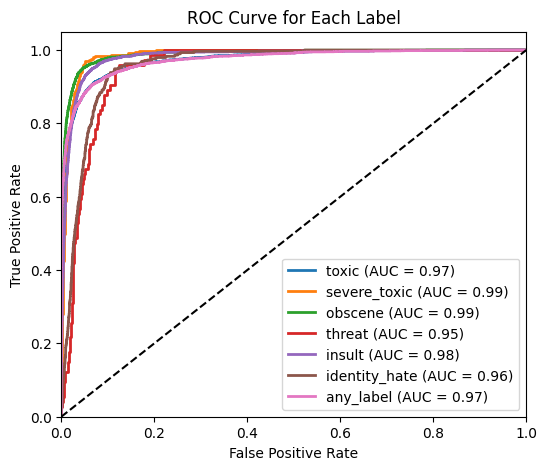

In [ ]:
# Create the ROC curve for each label
plt.figure(figsize=(6,5))
for i, label in enumerate(targets):
    # Get the decision function scores for each label
    y_pred_score = model.decision_function(X_test_nb)

    # In case it's multi-class, y_pred_score is already multi-dimensional, but here, we take scores for each label
    if y_pred_score.ndim > 1:
        y_pred_score_label = y_pred_score[:, i]
    else:
        y_pred_score_label = y_pred_score

    # Compute ROC curve
    fpr, tpr, _ = roc_curve(holdout_targets[label], y_pred_score_label)
    roc_auc = auc(fpr, tpr)

    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'{label} (AUC = {roc_auc:.2f})')

# Plot diagonal (random classifier)
plt.plot([0, 1], [0, 1], 'k--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Label')
plt.legend(loc='lower right')
plt.show()
